# 파이썬 - 웹크롤링 및 결과 비교분석
### 상반된 증감률을 보이는 시점별 지면기사 단어 빈도 비교를 통한 인사이트 도출
---
## 1.GOAL
- R분석을 통해 얻은 부동산 실거래 분기별 결과값을 통해 증감률이 상반된 분기들의 시점에 맞게 네이버 뉴스를 크롤링 한다.
- 기사를 통해 각 시점별 단어들의 밀집도를 비교 분석해 **인사이트 도출** 및 비교 분석한다.

## 2.TARGET PAGE
![2](https://user-images.githubusercontent.com/30791788/36558383-dacbbeaa-1802-11e8-898c-db54b17ff8d2.png)
- 박스가 그려져 있는 정보를 컨트롤 한다.

## 3.ISSUE
- 네이버 검색에서 날짜를 지정하면 동적으로 변화한 HTML값을 가져 올 수 없다. Selenium을 사용해 JavaScript로 랜더링 완료된 후의 결과값에 접근한다.
- 네이버 뉴스는 기사를 해당 언론사 페이지로 링크를 걸거나 자체 페이지로 취급하는 방식으로 운영하며 자체페이지로 생성하지 않은 경우도 있어 네이버 자체페이지로 생성하는 기사만 불러 오도록 한다.
- 객체지향 코딩
- 스크롤링 기준을 타이틀 or 본문 내용으로 선택이 가능하도록 코딩한다.

### ◎크롤링 코드◎

In [1]:
import numpy as np
import pymysql
import pandas as pd
import re
import urllib.request
from bs4 import BeautifulSoup
from selenium import webdriver

In [17]:
#크롤링의 메인을 담당하는 class

class makeSoup:
	def __init__(self, keyword1, start, end, pg = '1'): #keyword1 : 검색 할 키워드,  start : 시작 날짜, end : 종료 날짜, pg : 검색 페이지
		self.keyword1 = urllib.parse.quote(keyword1)
		self.start = start
		self.end = end
		self.pg = pg
		
	def makeUrl(self):	    #날짜 값을 받아 검색할 페이지 URL에 적용시킨다.
		
		start1 = self.start.replace('.','')
		end1 = self.end.replace('.','')
		mainUrl = 'https://search.naver.com/search.naver?ie=utf8&where=news&query='+self.keyword1+'&sm=tab_pge&sort=0&photo=3&field=0&reporter_article=&\
		pd=3&ds='+self.start+'&de='+self.end+'&docid=&nso=so:r,p:from'+start1+'to'+end1+',a:all&mynews=0&cluster_rank=11&start='+self.pg
		return(mainUrl)
        
	def webdriver(self, url, cp = '1'): #url : 입력 받을 url, cp : 한페이지에 10건의 뉴스링크가 있으며, 본문기사를 가져올 때  
                                        #                          불필요한 드라이버 호출을 없에기 위한 구분 매개변수
		self.url = url
		if cp == '1':                   #cp가 1일 경우만 PhantomJS드라이버를 호출하여 파싱한다.
			driver = webdriver.PhantomJS()    #동적페이지를 크롤링하기 위하여 PhaantomJS드라이버를 호출
			driver.get(self.url)
			rep = driver.page_source
			real_soup = BeautifulSoup(rep,'lxml')
			return(real_soup)
		else:                           #cp가 1일 아닐 경우 beautiful soup을 이용하여 request
			textUrl = urllib.request.Request(self.url)
			textRep = urllib.request.urlopen(textUrl).read()
			textSoup = BeautifulSoup(textRep,'lxml')
			return(textSoup)
	
	def cleantext(self,text):           #필요한 문자만 추출하는 함수.
		self.text = text
		cText = str(self.text)[:str(self.text).find('<a href')]				
		cText = re.sub('<.*?>','',cText)
		cText = re.sub('[\{\}\[\]\/?.,;:|\)*~`!^\n\t\r\-_+<>@\#$%&\\\=\(\'\"\u3000\u8000\xa0]','', cText)
		cText = re.sub('flash.*?back','',cText)
		return(cText)


In [3]:
#MySQL - R에서 생성한 테이블 추출
#dtname : 추출할 테이블 
def calldb(dtname):
    conn = pymysql.connect(host='localhost', user='root',
                           password='1234',db='APT', charset='utf8',
                           cursorclass=pymysql.cursors.DictCursor)

    sql = "select * from {}".format(dtname)        
    dt = pd.read_sql(sql, con = conn)
    conn.close()
    return(dt)

In [4]:
#분기별 상반된 증감률 계산, 분기 추출 함수 
#Mdt : 비교 대상 데이터
#Cdt : 비교 데이터
#col : mean_per, sd_per, med_per, n_per, sum_per 선택 중 선택
def CounterQ(Mdt,Cdt,col):
    
    no = np.array([int(x) for x in Mdt[col] > 0])
    o1 = np.array([int(x) for x in Cdt[col] < 0])

    return(Mdt['quter'][no + o1 == 2], Mdt['quter'][no + o1 == 0][1:]) 

In [13]:
#크롤링 process 함수
#keyword : 검색 할 키워드 입력
#Fdt : CounterQ 함수로 계산된 리스트입력 ex:['2013Q1','2014Q3']
#title : 뉴스 본문 or 제목 선택 매개변수 

def naverNews(keyword, Fdt, title = 'n'):
    
    exText = {}                      #{기사 날짜 : 본문 내용}                     
    titleBox = []                    #[검색하는 페이지의 타이틀] 
    
    for Quter in Fdt:                #리스트 원소에서 start, end 날짜값을 얻어낸다.
        
        day = Quter.split('Q')
        
        if day[1] == '1':
            start = day[0] + '.' + '01.01'
            end = day[0] + '.' + '03.31'
        if day[1] == '2':
            start = day[0] + '.' + '04.01'
            end = day[0] + '.' + '06.30'
        if day[1] == '3':
            start = day[0] + '.' + '07.01'
            end = day[0] + '.' + '09.30'
        if day[1] == '4':
            start = day[0] + '.' + '10.01'
            end = day[0] + '.' + '12.31'
        
######################################################################################################################
#검색 키워드로 검색 했을 시 총 뉴스 건수 찾아내는 코딩 : allN

        mainUrl = makeSoup(keyword,start,end)
        soup = mainUrl.webdriver(mainUrl.makeUrl())
        allN = int(re.findall('\d+',soup.find('div',{'class':'title_desc all_my'}).string)[2])

######################################################################################################################       
# 총 건수를 찾기 위해 먼저 request를 해와서 parshing을 한 값이 있기때문에 중복 처리나 같은 작업을 또 하지 않기 위해서 
# if문을 이용하여 분리 작업을 하도록 한다.

        for i in range(1,allN, 10):
        
            if i == 1 and title =='n':           #1번째 턴일때 본문 링크를 가져온다 
                arr = soup.findAll('a', {'class':re.compile('_sp_each_url')})   
            if i == 1 and title !='n':          #1번째 턴이고 title 매개변수가 n이 아닐때 파싱한 페이지에서 타이틀 추출
                                                #titleBox리스트에 하나의 원소가 아닌 각각의 원소로 append 한다.
                list(map(lambda x : titleBox.append(x), [l['title'] for l in soup.findAll('a',{'class':'_sp_each_title'})]))#중복 for문 방지
            elif i != 1: 
                mainUrl = makeSoup(keyword, start, end, str(i)) #2번째 for문이 실행 될때부터 수정된 url 입력받음 
                forSoup = mainUrl.webdriver(mainUrl.makeUrl())  #PhantomJs 파싱
			
                if title =='n':
                    arr = forSoup.findAll('a', {'class':re.compile('_sp_each_url')}) 
                else:
                    newsTitle = forSoup.findAll('a',{'class':'_sp_each_title'})

#######################################################################################################################
#title == n인 경우 감춰지는 for문 

                    for cn,tl in enumerate(newsTitle):
                        titleBox.append(tl['title'])
                    continue	

#title !=n 경우 하단의 for문이 구현될 필요가 없다.
#######################################################################################################################                
                
                for j in range(len(arr)):
                    li = arr[j].get('href')
                    exT = mainUrl.webdriver(li,'2')
                    exText[exT.find('span',{'class':'t11'}).string] = mainUrl.cleantext(exT.find('div',{'id':'articleBodyContents'}))
			
    if exText:		
        return(exText)		
    return(titleBox)	 


### ◎DB호출◎

In [6]:
normaldt = calldb('normalapt')
out15 = calldb('outtrade1')
out3 = calldb('outtrade3')

### ◎증감률이 상반된 분기◎ 

In [7]:
noUP, noDN = CounterQ(normaldt, out15, 'mean_per')

In [114]:
noUP_out3, noDN_out3 = CounterQ(normaldt, out3, 'mean_per')

### ◎크롤링◎ 

In [18]:
UPTitle = naverNews('서울시 아파트',noUP,'y')

C:\Anaconda3\lib\site-packages\selenium\webdriver\phantomjs\webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


In [20]:
DNTitle = naverNews('서울시 아파트',noDN,'y')

C:\Anaconda3\lib\site-packages\selenium\webdriver\phantomjs\webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


In [118]:
UPTitle3 = naverNews('서울시 아파트',noUP_out3,'y')

C:\Anaconda3\lib\site-packages\selenium\webdriver\phantomjs\webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


In [129]:
DNTitle3 = naverNews('서울시 아파트',noDN_out3,'y')

C:\Anaconda3\lib\site-packages\selenium\webdriver\phantomjs\webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


### ◎변수 설명◎
- - -
**NORUP_OUTDN** : Normal 데이터 상승 and OutLier1.5 데이터 하락 분기  
**NORDN_OUTUP** : Normal 데이터 하락 and OutLier1.5 데이터 상승 분기
- - - 
**NORUP_OUTDN3** : Normal 데이터 상승 and OutLier3 데이터 하락 분기  
**NORDN_OUTUP3** : Normal 데이터 하락 and OutLier3 데이터 상승 분기
- - -

In [148]:
print('NORUP_OUTDN -> ', list(noUP), '  지면기사 건수 -> ', len(UPTitle))
print('NORDN_OUTUP -> ', list(noDN), '\t\t\t','  지면기사 건수 -> ', len(DNTitle))
print('NORUP_OUTDN3 -> ', list(noUP_out3), ' 지면기사 건수 -> ', len(UPTitle3))
print('NORDN_OUTUP3 -> ', list(noDN_out3),'\t', '  지면기사 건수 -> ', len(DNTitle3))

NORUP_OUTDN ->  ['2013Q4', '2014Q3', '2015Q1', '2015Q2']   지면기사 건수 ->  2055
NORDN_OUTUP ->  ['2013Q3', '2014Q2'] 			   지면기사 건수 ->  989
NORUP_OUTDN3 ->  ['2014Q3', '2015Q2', '2015Q4', '2016Q3']  지면기사 건수 ->  1976
NORDN_OUTUP3 ->  ['2013Q2', '2014Q2', '2014Q4'] 	   지면기사 건수 ->  1426


### ◎결과확인◎

In [24]:
from konlpy.tag import Twitter   #형태소분석 패키지
from collections import Counter

In [187]:
#konlpy를 이용하여 단어 빈도 출력 함수
#no : 제외하고 싶은 단어 리스트
#cnText : 데이터 셋
#wCn : 최소 단어의 길이
#cCn : 최소 빈도 수 

def countWord(no, cnText, wCn = 1, cCn = 1):
                   
    tw = Twitter()                                  

    if type(cnText) == dict:                        #본문을 크롤링 할 경우 딕셔너리 형태로 값을 받는다
        cnText = ''.join(cnText.values())
    else:
        cnText = ''.join(cnText)                    #title만 크롤링 할 경우 리스트 형태로 값을 받는다

    nouns = tw.nouns(cnText)	                   
    count = Counter(nouns)                                  

    if wCn or cCn !=1:
        count = Counter({w:c for w,c in count.items() if len(w) >= wCn and c >= cCn and w not in no})
    return(count)

In [186]:
no = ['서울','서울시','아파트','가구','부동산','단지','관리','마을','사업'] #제외 할 단어

#### ⊙스크롤링한 기사 타이틀 시점 별 빈도⊙

In [188]:
UPQ = pd.Series(countWord(no, UPTitle, 2, 5))
DNQ = pd.Series(countWord(no, DNTitle, 2, 5))

In [189]:
UPQ3 = pd.Series(countWord(no, UPTitle3, 2, 5))
DNQ3 = pd.Series(countWord(no, DNTitle3, 2, 5))

#### ⊙단어 표준화⊙

In [190]:
df = pd.concat([UPQ,DNQ], axis = 1, keys = ['NORUP_OUTDN','NORDN_OUTUP'])
df = df.fillna(0) #NA값 0으로 치환

In [191]:
df3 = pd.concat([UPQ3,DNQ3], axis = 1, keys = ['NORUP_OUTDN3','NORDN_OUTUP3'])
df3 = df3.fillna(0) #NA값 0으로 치환

In [192]:
df = df.div(df.sum())*10000 #전체 빈도수를 10000 단어로 표준화
df.describe() 

,NORUP_OUTDN,NORDN_OUTUP
count,577.000000,577.000000
mean,17.331023,17.331023
std,23.194208,35.177542
min,0.000000,0.000000
25%,7.603406,0.000000
50%,12.165450,0.000000
75%,18.248175,26.726058
max,305.656934,467.706013


In [193]:
df3 = df3.div(df3.sum())*10000 #전체 빈도수를 10000 단어로 표준화
df3.describe() 

,NORUP_OUTDN3,NORDN_OUTUP3
count,608.000000,608.000000
mean,16.447368,16.447368
std,24.951920,28.524596
min,0.000000,0.000000
25%,8.145976,0.000000
50%,11.404366,12.827091
75%,17.921147,20.523345
max,391.006843,425.859415


#### ⊙Top20 단어, 합산 상위 40단어, 시점별 특정단어⊙

In [194]:
NORUP_OUTDN_20 = df.sort_values(by='NORUP_OUTDN', ascending=False)['NORUP_OUTDN'][:20]
NORDN_OUTUP_20 = df.sort_values(by='NORDN_OUTUP', ascending=False)['NORDN_OUTUP'][:20]

In [195]:
Merge_40 = pd.DataFrame((df['NORUP_OUTDN']+df['NORDN_OUTUP']).sort_values(ascending=False)[:40], columns=['합'])
Merge_40 = MergeTop20.merge(df,how='inner',left_index=True, right_index=True)

In [196]:
NORUP_OUTDNOnly = df[df['NORUP_OUTDN']-df['NORDN_OUTUP']==df['NORUP_OUTDN']].sort_values(by='NORUP_OUTDN',ascending=False)[:10]
NORDN_OUTUPOnly = df[df['NORDN_OUTUP']-df['NORUP_OUTDN']==df['NORDN_OUTUP']].sort_values(by='NORDN_OUTUP',ascending=False)[:10]

- - -

In [197]:
NORUP_OUTDN3_20 = df3.sort_values(by='NORUP_OUTDN3', ascending=False)['NORUP_OUTDN3'][:20]
NORDN_OUTUP3_20 = df3.sort_values(by='NORDN_OUTUP3', ascending=False)['NORDN_OUTUP3'][:20]

In [198]:
Merge3_40 = pd.DataFrame((df3['NORUP_OUTDN3']+df3['NORDN_OUTUP3']).sort_values(ascending=False)[:40], columns=['합'])
Merge3_40 = Merge3_40.merge(df3,how='inner',left_index=True, right_index=True)

In [199]:
NORUP_OUTDN3Only = df3[df3['NORUP_OUTDN3']-df3['NORDN_OUTUP3']==df3['NORUP_OUTDN3']].sort_values(by='NORUP_OUTDN3',ascending=False)[:10]
NORDN_OUTUP3Only = df3[df3['NORDN_OUTUP3']-df3['NORUP_OUTDN3']==df3['NORDN_OUTUP3']].sort_values(by='NORDN_OUTUP3',ascending=False)[:10]

- - - 

### ◎그래프 확인◎

In [82]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

In [39]:
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

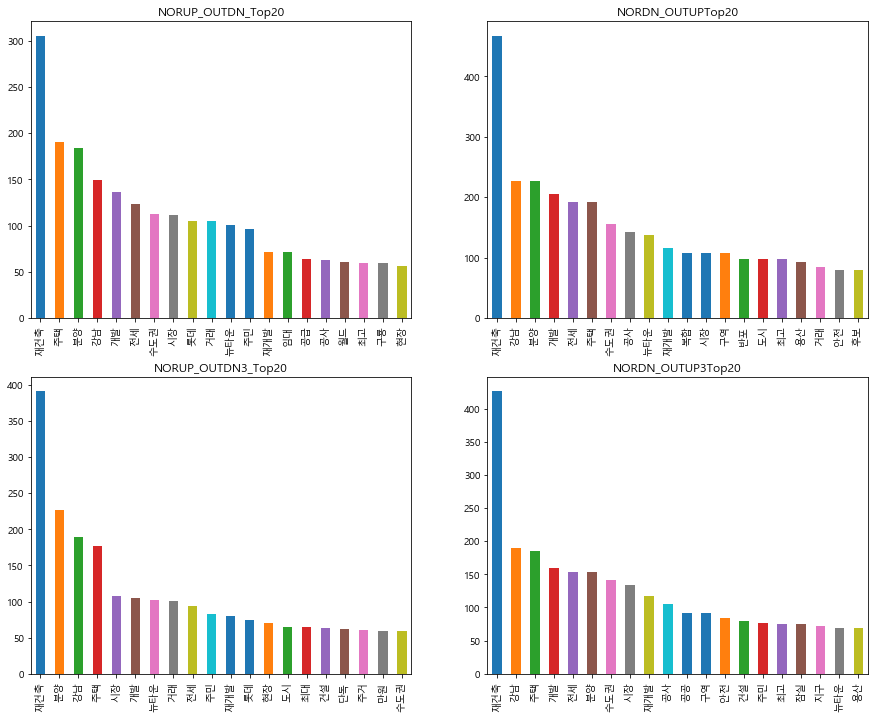

In [200]:
#NORUP_OUTDN NORDN_OUTUP Top20 그래프 
fig,axes = plt.subplots(2,2)
fig.set_size_inches(15, 12)
NORUP_OUTDN_20.plot(kind='bar', ax=axes[0,0], title='NORUP_OUTDN_Top20')
NORDN_OUTUP_20.plot(kind='bar', ax=axes[0,1], title='NORDN_OUTUPTop20')
NORUP_OUTDN3_20.plot(kind='bar', ax=axes[1,0], title='NORUP_OUTDN3_Top20')
NORDN_OUTUP3_20.plot(kind='bar', ax=axes[1,1], title='NORDN_OUTUP3Top20')

NORUP_OUTDN ->  ['2013Q4', '2014Q3', '2015Q1', '2015Q2']
NORDN_OUTUP ->  ['2013Q3', '2014Q2']
NORUP_OUTDN3 ->  ['2014Q3', '2015Q2', '2015Q4', '2016Q3']
NORDN_OUTUP3 ->  ['2013Q2', '2014Q2', '2014Q4']


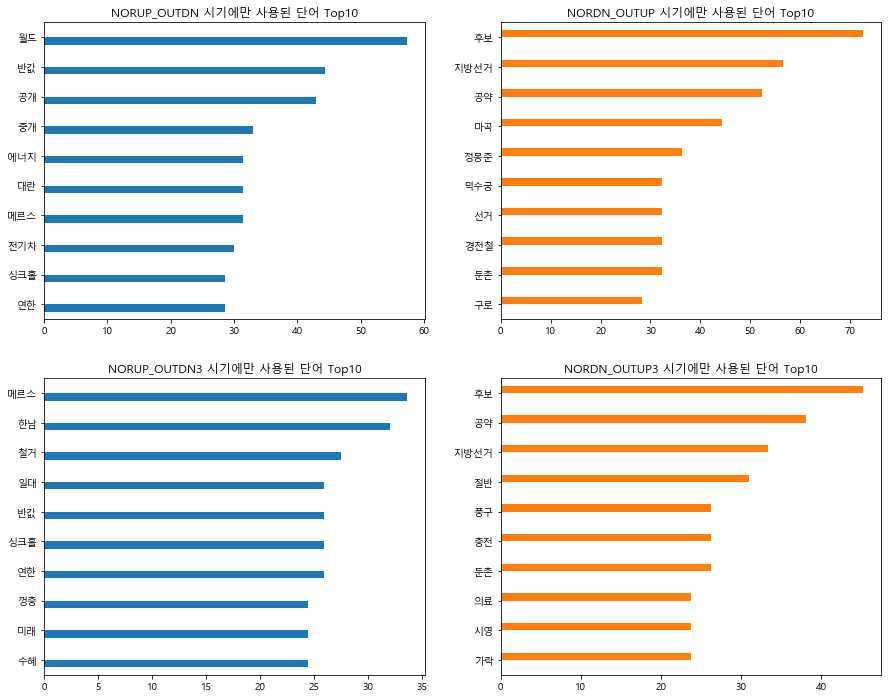

In [185]:
print('NORUP_OUTDN -> ',list(noUP))
print('NORDN_OUTUP -> ',list(noDN))
print('NORUP_OUTDN3 -> ', list(noUP_out3))
print('NORDN_OUTUP3 -> ', list(noDN_out3))
fig,axes = plt.subplots(2,2)
fig.set_size_inches(15, 12)
NORUP_OUTDNOnly.sort_values(by='NORUP_OUTDN').plot(ax=axes[0,0], kind='barh', title='NORUP_OUTDN 시기에만 사용된 단어 Top10', legend=False)
NORDN_OUTUPOnly.sort_values(by='NORDN_OUTUP').plot(ax=axes[0,1], kind='barh', title='NORDN_OUTUP 시기에만 사용된 단어 Top10', legend=False)
NORUP_OUTDN3Only.sort_values(by='NORUP_OUTDN3').plot(ax=axes[1,0], kind='barh', title='NORUP_OUTDN3 시기에만 사용된 단어 Top10', legend=False)
NORDN_OUTUP3Only.sort_values(by='NORDN_OUTUP3').plot(ax=axes[1,1], kind='barh', title='NORDN_OUTUP3 시기에만 사용된 단어 Top10', legend=False)

### PS & TODO
 네이버뉴스 기사중 지면기사 카테고리의 뉴스들의 본문을 스크롤링하여 분석할 계획이었으나 과부화 문제가 발생하여 타이틀 분석으로 방향을 선회 할 수밖에 없었다. 
  
 단어들이 전체적으로 비슷한 분포를 가지고 있으며 모든 시점에서 **재건축**이 앞도적으로 노출이  되고있다. 특이점은 **NORDN_OUTUP**시점에 공통적으로 선거에 관련한 단어들이 노출되고 있다.  **NORDN_OUTUP**시점에 **지역(용산,잠실,반포,둔촌,가락,구로)의** 언급이 자주 출현한다. 
 
 부동산 대책이 실효성이 있을까에 대한 의문에는 2014년3분기는  **NORUP_OUTDN** 시점이며 대책또한 서민주거 안정강화 방안이 주를 이룬다. 그러나 2015년 또한 비슷한 시점이고 대책 또한 같은 방향성을 가지지만 R분석결과에서는 거래량이 급등 하였으며 가장 많은 OUTLIER를 가진 해이기도 하다. 부동산시장은 특정한 계절에 계절성 주기를 가진다고 하기에도 실제 데이터는 고른 분포를 가지고 있어 좀 더 많은 데이터를 확보 할 필요가 있다.
  램덤프 문제 해결, 수집환경(하둡을 분산환경)갖춰 카페나 SNS등 커뮤니티 데이터도 융합하여 진행한다면 유의미한 결과를 가질 것이다.  